# Messung der RIR mit Sinus-Sweep

In [1]:
%matplotlib widget
import pyrato
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
from utils.edc import truncated_schroeder_integration
from utils.plot import attach_fractional_octave_ticker
from scipy.signal import find_peaks
np.seterr(divide='ignore');

## Importiere die gemessene Raumimpulsanwort

In [2]:
RIRs = pf.io.read_audio('../data/rir_sweep_fft_17.wav')
sampling_rate = RIRs.sampling_rate
RIRs = pf.dsp.normalize(RIRs)

Bestimme das Interval zur Schätzung der Rauschleistung

In [3]:
estimation_interval = np.array([1.5, 2]) / RIRs.times[-1]

Bandpassfilterung 1 kHz Oktav

In [4]:
idx = 0 
RIR_bandpass = pf.dsp.normalize(
    pf.dsp.filter.fractional_octave_bands(
        RIRs[idx], 1, freq_range=[990, 1100]))

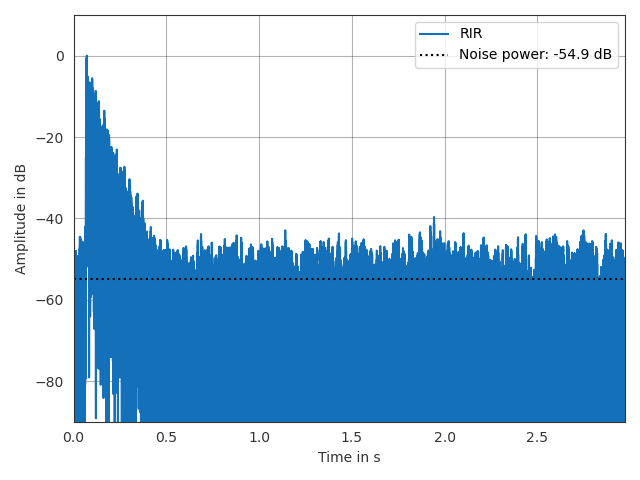

In [5]:
noise_power = float(pyrato.dsp._estimate_noise_energy(RIR_bandpass.time**2, estimation_interval))
plt.figure()
ax = pf.plot.time(RIR_bandpass, dB=True, label='RIR')
ax.axhline(
    10*np.log10(noise_power),
    linestyle=':', color='k',
    label=f'Noise power: {10*np.log10(noise_power):.1f} dB')
ax.legend();

# Verbesserung des Signal zu Störabstands

- Pro Verdopplung der Messdauer + 3 dB SNR
- Pro Verdopplung der Anzahl der Mittelungen + 3 dB SNR
- $10 \cdot \log_{10} N$ dB SNR Gewinn für $N$ Mittelungen

In [6]:
n_averages = 3
10*np.log10(n_averages)

4.771212547196624

In [7]:
RIR_bandpass_avg = pf.dsp.normalize(
    pf.dsp.filter.fractional_octave_bands(
        pf.dsp.average(RIRs[:n_averages-1]), 1, freq_range=[990, 1100]))

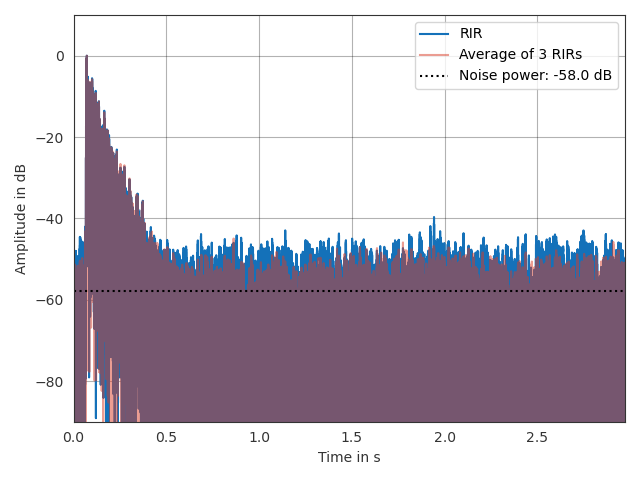

In [8]:
idx = 0
noise_power = float(pyrato.dsp._estimate_noise_energy(RIR_bandpass_avg.time**2, estimation_interval))
plt.figure()
ax = pf.plot.time(RIR_bandpass, dB=True, label='RIR')
ax = pf.plot.time(RIR_bandpass_avg, dB=True, label='Average of 3 RIRs', alpha=0.5)

ax.axhline(
    10*np.log10(noise_power),
    linestyle=':', color='k',
    label=f'Noise power: {10*np.log10(noise_power):.1f} dB')
ax.legend();

**Aufgabe: Wie viele Mittelungen müssen durchgeführt werden um einen SNR Gewinn von 10 dB zu erhalten?**

$G = 10 \cdot \log_{10} N$ dB SNR Gewinn für $N$ Mittelungen

$N = 10^{\frac{G}{10}}$ Mittelungen für einen SNR Gewinn von G in dB

In [9]:
N = 10**(10/10)
print(N)

10.0


In [10]:
N*5.9/60

0.9833333333333333

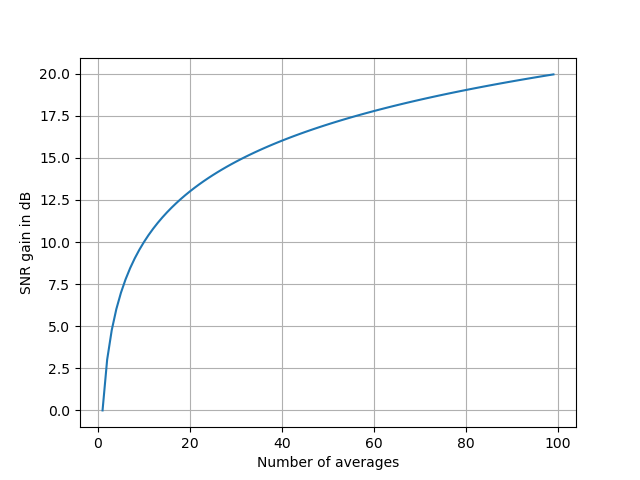

In [11]:
N_array = np.arange(1, 100) 
_, axs = plt.subplots(1, 1, )

axs.plot(N_array, 10*np.log10(N_array))
axs.set_xlabel("Number of averages") 
axs.set_ylabel("SNR gain in dB")
axs.grid(True)

# Berechnung der Abklingkurve

In [12]:
int_times = pyrato.intersection_time_lundeby(
    RIR_bandpass, freq='broadband')[0]
print(f"t_i = {float(int_times):.2f}")

t_i = 0.41


In [13]:
edc = truncated_schroeder_integration(RIR_bandpass, int_times)
edc = edc / edc.time[0, 0]

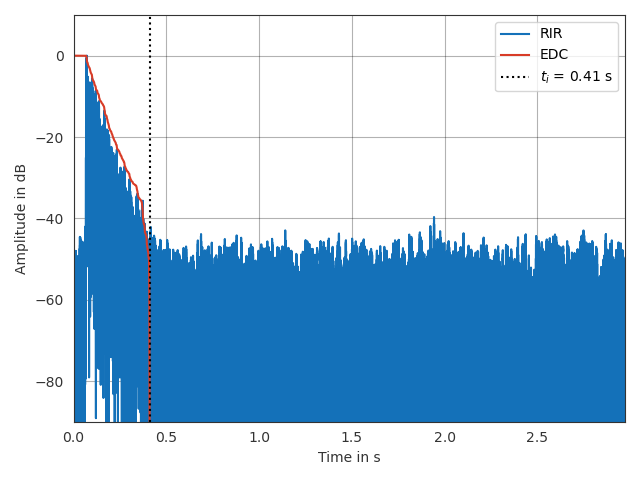

In [14]:
plt.figure()
ax = pf.plot.time(RIR_bandpass, dB=True, label='RIR')
pf.plot.time(edc, dB=True, log_prefix=10, label='EDC')
ax.axvline(
    float(int_times), label=f'$t_i$ = {float(int_times):.2f} s',
    color='k', linestyle=':')
plt.legend();

Benutze die $T_{20}$ zur Bestimmung der Nachhallzeit

In [15]:
interval = 20

In [16]:
reverberation_times, intercept = pyrato.reverberation_time_linear_regression(
    edc, return_intercept=True, T=f"T{interval}")
print(f"T{interval} = {float(reverberation_times):.2f} s")

T20 = 0.47 s


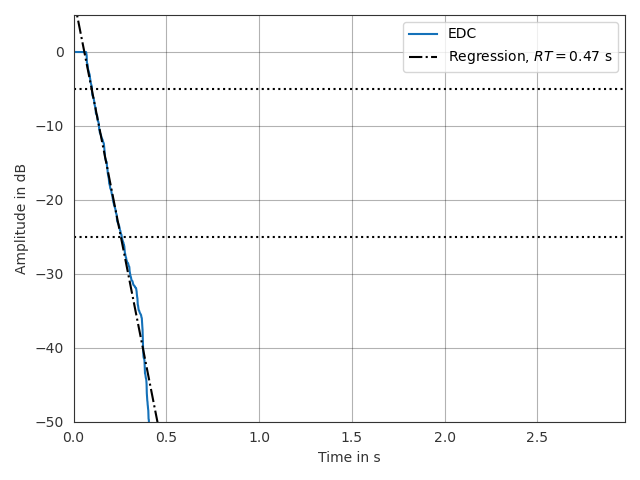

In [17]:
edc_model = 10*np.log10(
    intercept*np.exp(-13.8*edc.times/reverberation_times[0]))

plt.figure()
ax = pf.plot.time(edc, dB=True, log_prefix=10, label='EDC')
ax.plot(
    edc.times, edc_model, color='k', linestyle='-.',
    label=f'Regression, $RT={float(reverberation_times):.2f}$ s')
ax.set_ylim((-50, 5))
ax.axhline(-5, color='k', linestyle=':')
ax.axhline(-5-interval, color='k', linestyle=':')
plt.legend();


# Frequenzabhängigkeit der Anregung

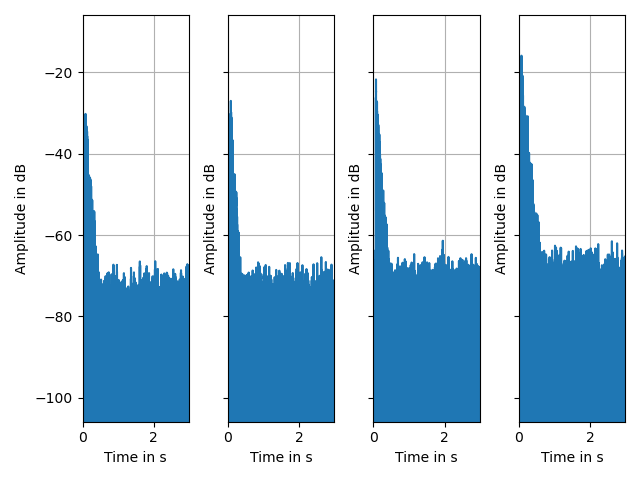

In [18]:
bands = [250, 500, 1e3, 2e3]
# band = bands[1]

fig, axs = plt.subplots(1, len(bands), sharey=True, sharex=True)

for idx, band in enumerate(bands):
    RIR_bandpass = pf.dsp.filter.fractional_octave_bands(
        RIRs[0], 1, freq_range=np.array([0.9, 1.1])*band)
    pf.plot.time(RIR_bandpass, dB=True, ax=axs[idx])
    axs[idx].grid(True)

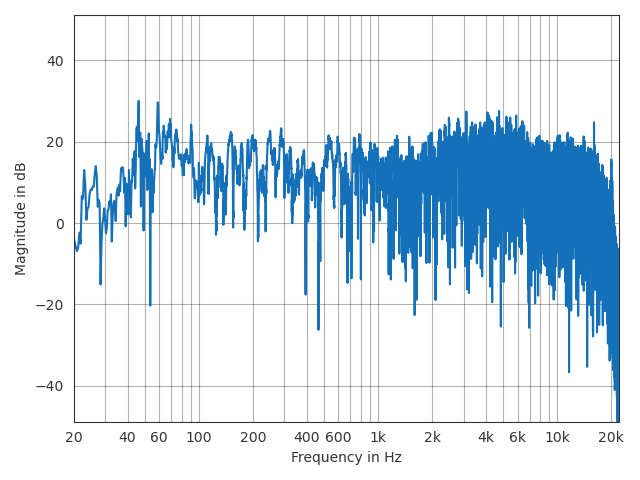

In [19]:
plt.figure()
pf.plot.freq(RIRs[0]);

# Auswertung in Terzen

In [20]:
freq_range = (500, 15e3)

rirs_bands = pf.dsp.filter.fractional_octave_bands(
    pf.dsp.average(RIRs), 3, freq_range=freq_range)

bands = pf.dsp.filter.fractional_octave_frequencies(3, frequency_range=freq_range)[0]
edcs = pyrato.energy_decay_curve_chu_lundeby(rirs_bands)
rts = pyrato.reverberation_time_linear_regression(edcs)

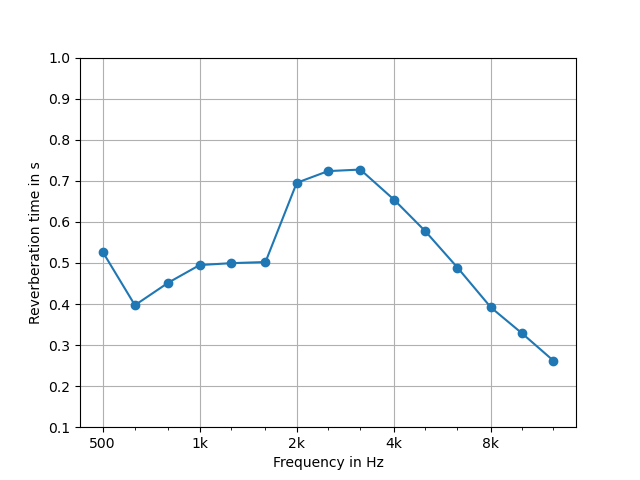

In [21]:
plt.figure()
ax = plt.axes()
ax.semilogx(bands, rts, marker='o')
ax.grid(True)
attach_fractional_octave_ticker(ax, 1, 3)
ax.set_ylabel("Reverberation time in s")
ax.set_xlabel("Frequency in Hz")
ax.set_ylim((0.1, 1));